# **pAIcasso code**
#### Matthew Ivler, Renae Tamura

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import os
from random import randint
import time
import pandas as pd
import seaborn as sns

### Define hyperparameters, import images, and create standardized dataset

In [2]:
# global variables/hyperparameters
data_path = "/tmp/dataset_paicasso/cleaned/"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

batch_sizes = 32
lr = .001
num_epochs = 300
input_size = 256**2
art_styles = ["AbstractArt", "ContemporaryArt", "CubistArt", "GongbiArt", "ImpressionistArt", "KenteArt", "Min-hwaArt", "ModernArt", "MughalArt", "SurrealistArt", "XieyiArt", "FakeArt"]
num_styles = len(art_styles)

cuda:3


In [3]:
# Get images to format (Tensor, Style)
class Images_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, images_styles, transforms):
        super().__init__()
        self.images = [entry[0] for entry in images_styles]
        self.labels = [entry[1] for entry in images_styles]
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label_vector = [0 for i in range(num_styles)]
        style_index = art_styles.index(self.labels[idx])
        label_vector[style_index] = 1
        image = self.images[idx]
        image_new = image.convert("RGB")
        return self.transforms(image_new), torch.tensor(label_vector)
    

In [4]:
# Get images to PIL format
def create_dataset(data_path, wanted_files, transforms=transforms.ToTensor()):
    """
    Creates the dataset to be loaded in later.
    :param: data_path (str) - the path to directory separated images of interest
    :param: wanted_files (list)- a list of file names that are for either the training or validation dataset
    :param: transforms (torch.transforms) - list of transforms to apply to images
    :return: dataset (Image_Dataset) - the dataset of elements as (transformed image tensors, style_label)
    """
    
    file_names = {}
    images = []
    for root, dirs, _ in os.walk(data_path):
        for directory in dirs:
            files = glob(root + directory + "/*.*")
            file_names[directory] = files
        for directory, file_list in file_names.items():
            for file in file_list:
                if file in wanted_files:
                    image = Image.open(file)
                    images.append((image, directory))
    del file_names
    
    return Images_Dataset(images, transforms)

In [5]:
def check_datapoint(data, x):
    '''
    data: training or validation data
    x: index at which we wish to view data
    Checks the image and label of the parameters given
    '''
    example = data[x]
    image = example[0]
    style = example[1]
    print(image.shape)
    image_ = image.permute(1, 2, 0) 
    plt.imshow(image_)
    plt.show()
    print(style)

In [6]:
def create_data_file():
    '''
    creates a file that contains all training and validation data
    only needs to be ran once
    '''
    files = []
    for root, dirs, _ in os.walk(data_path):
            for directory in dirs:
                files_in_dir = glob(root + directory + "/*.*")
                files.extend(list(files_in_dir))

    dataset_size = len(files)
    training_prop = .7
    training_indices = []

    while len(training_indices) < dataset_size*training_prop:
        new_index = randint(0, dataset_size-1)
        if new_index not in training_indices:
            training_indices.append(new_index)

    validation_indices = [x for x in range(0, dataset_size) if x not in training_indices]
    training_string = " ".join([files[x] for x in training_indices])
    validation_string = " ".join([files[x] for x in validation_indices])

    with open("training_validation_indices.txt", "w") as outf:
        outf.write(f"training:\t{training_string}\n")
        outf.write(f"validation:\t{validation_string}\n")

In [36]:
def separate_data():
    '''
    Separates data into training and validation sets
    initializes the training and validation sets as well 
    '''
    with open("training_validation_indices.txt", "r") as infile:
        training_files = infile.readline().split("\t")[1].split()
        validation_files = infile.readline().split("\t")[1].split()    

    
    # Transformers, more than meets the eye!
    transformers = transforms.Compose([
                             transforms.Resize(256),
                             transforms.RandomCrop(256),
                             transforms.RandomHorizontalFlip(p=.45),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                )

    training_data = create_dataset(data_path, training_files, transformers)
    validation_data = create_dataset(data_path, validation_files, transformers)
    
    return transformers, training_files, validation_files, training_data, validation_data

### Create noise and labels for image generation

In [33]:
def rand_generator_input():
    '''
    Function to generate random input of size [batch_size, 101, 1, 1] 
    The data consists of random noise and a target style piece appended to
    the 100 items of random noise
    '''
    # create batches separately then concatenate them all together 
    targets = []
    tensors = []
    for item in range(batch_sizes):
        noise = torch.randn(101, 1, 1)
        target_category = randint(0, len(art_styles)-2)
        noise[100] = target_category
        tensors.append(noise)
        targets.append(target_category)
    return torch.stack(tensors), torch.tensor(targets)

In [27]:
def gen_fake_labels():
    '''
    Function to create labels for fake images with output of [batch_size, 12]
    '''
    fake = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,1])
    fakes = []
    for i in range(batch_sizes):
        fakes.append(fake)
    return torch.stack(fakes)

### Define the discriminator and the generator models

In [28]:
class Discriminator(nn.Module):
    '''
    Discriminator class that holds the discriminator model
    Model consists of 7 convolutional layers a flattening layer, and a linear layer
    '''
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        #was 3 -> 54 -> 36 -> 24 -> 16 ->9 ->6 -> 4 -> 1
        self.ConvSet1 = nn.Sequential(
                        nn.Conv2d(3, 32, (4,4), 2, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU()
                        )
        
        self.ConvSet2 = nn.Sequential(
                        nn.Conv2d(32, 16, (4,4), 2, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU()
                        )
        
        self.ConvSet3 = nn.Sequential(
                        nn.Conv2d(16, 12, (4,4), 2, padding=1),   
                        nn.BatchNorm2d(12),
                        nn.ReLU()
                        )
        
        self.ConvSet4 = nn.Sequential(
                        nn.Conv2d(12, 6, (4,4), 2, padding=1),
                        nn.BatchNorm2d(6),
                        nn.ReLU()
                        )
        
        self.ConvSet5 = nn.Sequential(
                        nn.Conv2d(6, 4, (3,3), padding=1),
                        nn.BatchNorm2d(4),
                        nn.ReLU(),
                        )
        
        self.ConvSet6 = nn.Sequential(
                        nn.Conv2d(4, 3, (3,3), padding=1),
                        nn.BatchNorm2d(3),
                        nn.ReLU()
                        )
        
        
        self.ConvSet8 = nn.Sequential(
                        nn.Conv2d(3, 1, (3,3), padding=1),
                        nn.BatchNorm2d(1),
                        nn.ReLU()
                        )
        
        self.flat = nn.Flatten()
        self.linears = nn.Sequential(
                        nn.Linear(256, 128),
                        nn.Dropout(p=0.2),
                        nn.Linear(128, 64),
                        nn.Dropout(p=0.2),
                        nn.Linear(64, output_size),
                        )
    
    def forward(self, X):
        x = self.ConvSet1(X)
        Y = self.ConvSet2(x)
        y = self.ConvSet3(Y)
        Z = self.ConvSet4(y)
        z = self.ConvSet5(Z)
        Q = self.ConvSet6(z)
        M = self.ConvSet8(Q)
        W = self.flat(M)
        w = self.linears(W)
        return w

In [29]:
class Generator(nn.Module):
    '''
    Generator model that includes an initial linear model to handle the 101th piece
    of data that represents the target style
    Generator then has 7 convolutional layers to create the image
    '''
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(101, 100)
        
        self.ConvSet1 = nn.Sequential(
                            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
                            nn.BatchNorm2d(1024),
                            nn.ReLU(True)
                        )
        
        self.ConvSet2 = nn.Sequential(
                            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(512),
                            nn.ReLU(True)
                        )

        self.ConvSet3 = nn.Sequential(
                            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(256),
                            nn.ReLU(True)
                        )
        
        self.ConvSet4 = nn.Sequential(
                            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(128),
                            nn.ReLU(True)
                        )
        
        self.ConvSet5 = nn.Sequential(
                            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(64),
                            nn.ReLU(True)
                        )
        
        self.ConvSet6 = nn.Sequential(
                            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(64),
                            nn.ReLU(True)
                        )


        self.ConvSet7 = nn.Sequential(
                            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                            nn.Tanh()
                        )

    def forward(self, X):
        x = self.linear1(X)
        Y = self.ConvSet1(x.unsqueeze(2).unsqueeze(3))
        y = self.ConvSet2(Y)
        Z = self.ConvSet3(y)
        z = self.ConvSet4(Z)
        W = self.ConvSet5(z)
        w = self.ConvSet6(W)
        V = self.ConvSet7(w)
        return V

### Testing the discriminator to adjust hyperparameters
(Do not run unless testing only the discriminator)

In [37]:
create_data_file()
transformers, training_files, validation_files, training_data, validation_data = separate_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18996
torch.Size([3, 256, 256])


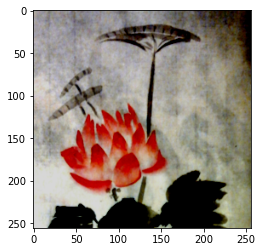

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8136
torch.Size([3, 256, 256])


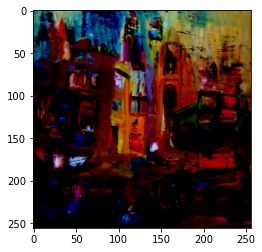

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [38]:
'''
This cell is for checking the length of the data files, 
and checking the datapoints at two random places
'''
training_data = create_dataset(data_path, training_files, transformers)
print(len(training_data))
check_datapoint(training_data, 6232)

validation_data = create_dataset(data_path, validation_files, transformers)
print(len(validation_data))
check_datapoint(validation_data, 500)

In [10]:
'''
Cell for training the discriminator on training data, 
Evaluating training on validation data, and 
Printing out results and accuracy from validation 
'''

# define training and validation dataloaders
training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_sizes, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_sizes, shuffle=True)

discriminator = Discriminator(input_size, len(art_styles))

discriminator.to(device)
discriminator.train()

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(discriminator.parameters(), lr=lr)
num_epochs = 15

# begin training 
for epoch in range(num_epochs):
    start = time.perf_counter() 
    cumulative_loss_in_epoch = 0
    
    for images, labels in training_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = discriminator(images)
        
        optimizer.zero_grad()
        loss = loss_func(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()
        
        cumulative_loss_in_epoch += loss.item()
    end = time.perf_counter()
    print((end-start)/60)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {cumulative_loss_in_epoch}")
    
# begin evaluation of discriminator 
# empty cuda cache to hopefully get more storage
torch.cuda.empty_cache()
discriminator.to(device)
discriminator.eval()

# testing discriminator on validation set 
correct = 0
total = 0

style_correct = [0 for _ in art_styles]
style_total = [0 for _ in art_styles]

with torch.no_grad():

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = discriminator(images)

        predictions = outputs.argmax(dim=1, keepdim=True)
        labels = labels.argmax(dim=1, keepdim=True)

        comparisons = predictions.eq(labels.view_as(predictions))

        for comp, label in zip(comparisons, labels):
            style_correct[label] += comp.item()
            style_total[label] += 1

        total += labels.shape[0]
        correct += int(comparisons.double().sum().item())
        del images
        del labels

accuracy = correct / total
print(f"Accuracy on validation set: {correct}/{total} = {accuracy*100:.2f}%")

for i, label in enumerate(art_styles):
    s_correct = style_correct[i]
    s_total = style_total[i]

    s_accuracy = s_correct / s_total
    print(f"Accuracy on {label:>5} class: {s_correct}/{s_total} = {s_accuracy*100:.2f}%")


### Training and evaluating the GAN
(This is the main part of our code that loops through the data and trains the discriminator and the generator in tandem. We then evaluate the code on the validation set and create a confusion matrix for it). 

In [14]:
def train_GAN(): 
    '''
    Function for training the GAN
    Takes the images in the dataset and trains on them and generated images
    Prints out the loss for discriminator, generator, and total each epoch
    '''
    # create dataloaders
    training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_sizes, shuffle=True)

    # initialize generator and discriminator for training
    generator = Generator()
    generator.to(device)
    generator.train()
    discriminator = Discriminator(input_size, len(art_styles))
    discriminator.to(device)
    discriminator.train()

    # initialize loss function and optimizers 
    loss_func = nn.CrossEntropyLoss()
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr)

    # train on data for the number of epochs specified
    for epoch in range(num_epochs):
        start = time.perf_counter() 
        total_loss = 0
        disc_total_loss = 0
        gen_total_loss = 0

        for images, labels in training_loader:
            # real images and labels 
            real_images = images.to(device)
            real_labels = labels.to(device)

            # real_labels = torch.ones((batch_sizes, 1))
            data_to_generate = rand_generator_input()[0]
            data_to_generate = data_to_generate.to(device)
            generated_images = generator(data_to_generate.squeeze())
            generated_images = generated_images.to(device)
            generated_labels = gen_fake_labels()
            generated_labels = generated_labels.to(device)

            all_images = torch.cat((real_images, generated_images))
            all_images.to(device)
            all_labels = torch.cat((torch.max(real_labels, 1)[1], torch.max(generated_labels, 1)[1]))
            all_labels.to(device)

            # train the discriminator
            disc_optimizer.zero_grad()
            disc_output = discriminator(all_images)
            disc_loss = loss_func(disc_output, all_labels)
            disc_loss.backward()
            disc_optimizer.step()
            disc_total_loss += disc_loss.item()
            total_loss += disc_loss.item()

            # data for training generator
            data_to_generate, target_labels = rand_generator_input()
            data_to_generate = data_to_generate.to(device)
            target_labels = target_labels.to(device)

            # Training generator
            gen_optimizer.zero_grad()
            generated_images = generator(data_to_generate.squeeze())
            disc_gen_output = discriminator(generated_images)
            gen_loss = loss_func(disc_gen_output, target_labels)
            gen_loss.backward()
            gen_optimizer.step()
            gen_total_loss += gen_loss.item()
            total_loss += gen_loss.item()
            

        end = time.perf_counter()
        print((end-start)/60)    
        print(f"Epoch: {epoch+1}/{num_epochs}, Disc: {disc_total_loss}, Gen: {gen_total_loss}, Total: {total_loss}")
    
    print(f"Finished training GAN")
    return discriminator, generator

In [15]:
class Confusion_Matrix:
    def __init__(self, length):
        self.matrix = {}
        for i in range(length):
            self.matrix[i] = [[0 for elem in range(length)], 0]
        self.length = length
        print(self.matrix)
    def update(self, real_labels, predicted_labels):
        for i in range(len(real_labels)):
            self.matrix[real_labels[i][0].item()][0][int(predicted_labels[i][0].item())] += 1
            self.matrix[real_labels[i][0].item()][1] += 1
    def show(self):
        for style in self.matrix.values():
            array = style[0]
            total_of_style = style[1]
            for i in range(len(array)):
                if total_of_style > 0:
                    array[i] = array[i]/total_of_style
            print(total_of_style)
        matrix = [self.matrix[i][0] for i in range(self.length)]
        matrix_arrays = pd.DataFrame(matrix, index = [style for style in art_styles], columns = [style for style in art_styles])
        plt.figure(figsize = (10,7))
        heatmap = sns.heatmap(matrix_arrays, annot=True)
        plt.xlabel("Predicted Styles") 
        plt.ylabel("Real Styles")
        return heatmap

In [16]:
def evaluate_GAN():    
    '''
    Evaluates the trained GAN on the validation set and generated data
    Prints the accuracy for the discriminator and generator afterwards 
    '''
    # empty cache and initialize for evaluation 
    torch.cuda.empty_cache()
    discriminator.to(device)
    generator.to(device)
    discriminator.eval()
    generator.eval()
    
    # create validation dataloader
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_sizes, shuffle=True)

    # initialize variables for holding correct / total values 
    disc_correct = 0
    disc_total = 0
    gen_correct = 0
    gen_total = 0
    disc_style_correct = [0 for _ in art_styles]
    disc_style_total = [0 for _ in art_styles]
    gen_style_correct = [0 for _ in art_styles]
    gen_style_total = [0 for _ in art_styles]

    # create confusion matrix
    matrix = Confusion_Matrix(len(art_styles))
    
    # evaluate in batches 
    with torch.no_grad():
        for images, labels in validation_loader:
            if(images.shape != torch.Size([batch_sizes, 3, 256, 256])):
                break
            # real images and labels 
            real_images = images.to(device)
            real_labels = labels.to(device)

            # real_labels = torch.ones((batch_sizes, 1))
            data_to_generate, target_labels = rand_generator_input()
            data_to_generate = data_to_generate.to(device)
            target_labels = target_labels.to(device)
            generated_images = generator(data_to_generate.squeeze())
            generated_images = generated_images.to(device)
            generated_labels = gen_fake_labels()
            generated_labels = generated_labels.to(device)

            all_images = torch.cat((real_images, generated_images))
            all_images.to(device)
            all_labels = torch.cat((torch.max(real_labels, 1)[1], torch.max(generated_labels, 1)[1]))
            all_labels.to(device)

            # obtain accuracy of discriminator with both real and fake pictures
            output = discriminator(all_images)
            predictions = output.argmax(dim=1, keepdim=True)
            comparisons = predictions.eq(all_labels.view_as(predictions))

            for comp, label in zip(comparisons, all_labels):
                disc_style_correct[label] += comp.item()
                disc_style_total[label] += 1

            disc_total += all_labels.shape[0]
            disc_correct += int(comparisons.double().sum().item())
            del real_images
            del real_labels

            # obtain accuracy of generator with only fake images
            gen_predictions = torch.reshape(predictions, (2, batch_sizes))[1]
            gen_comparisons = gen_predictions.eq(target_labels.view_as(gen_predictions))

            for comp, label in zip(gen_comparisons, target_labels):
                gen_style_correct[label] += comp.item()
                gen_style_total[label] += 1

            gen_total += target_labels.shape[0]
            gen_correct += int(gen_comparisons.double().sum().item())
            
            # update confusion matrix
            matrix.update(all_labels.unsqueeze(1), predictions)
            
            # delete unnecessary data 
            del data_to_generate
            del all_images
            del all_labels

    # print discriminator accuracy
    disc_accuracy = disc_correct / disc_total
    print(f"Discriminator accuracy on validation set: {disc_correct}/{disc_total} = {disc_accuracy*100:.2f}%")

    for i, label in enumerate(art_styles):
        d_correct = disc_style_correct[i]
        d_total = disc_style_total[i]
        if d_total == 0:
            d_accuracy = 0
        else:
            d_accuracy = d_correct / d_total
        print(f"Discriminator accuracy on {label:>5} class: {d_correct}/{d_total} = {d_accuracy*100:.2f}%")

    # print generator accuracy 
    gen_accuracy = gen_correct / gen_total
    print(f"\nGenerator accuracy on validation set: {gen_correct}/{gen_total} = {gen_accuracy*100:.2f}%")

    for i, label in enumerate(art_styles):
        g_correct = gen_style_correct[i]
        g_total = gen_style_total[i]
        if g_total == 0:
            g_accuracy = 0
        else:
            g_accuracy = g_correct / g_total
        print(f"Generator accuracy on {label:>5} class: {g_correct}/{g_total} = {g_accuracy*100:.2f}%")
    
    # show confusion matrix
    matrix.show()
    
    return target_labels, generated_images


In [17]:
def save_generated_image(style_num):
    img_name = str(art_styles[style_num]) + "Generated.jpg"
    val = torch.min((target_labels == style_num).nonzero(as_tuple=True)[0])
    img = generated_images[val.item()]
    utils.save_image(img, img_name)
    
    # show image
    plt.imshow(generated_images[val.item()].cpu().permute(1,2,0))

#### Note that these cells run the above definitions of functions

In [39]:
create_data_file()
transformers, training_files, validation_files, training_data, validation_data = separate_data()

In [18]:
discriminator, generator = train_GAN()

13.63719312575025
Epoch: 1/300, Disc: 613.4870188236237, Gen: 1323.5429834127426, Total: 1937.0300022363663
4.258925480488688
Epoch: 2/300, Disc: 481.28185415267944, Gen: 659.6480375230312, Total: 1140.9298916757107
4.265300543637325
Epoch: 3/300, Disc: 445.96645852923393, Gen: 410.6215886324644, Total: 856.5880471616983
4.270000885395954
Epoch: 4/300, Disc: 419.39746284484863, Gen: 317.069939147681, Total: 736.4674019925296
4.268469909547518
Epoch: 5/300, Disc: 400.7360010445118, Gen: 286.1336996592581, Total: 686.8697007037699
5.016661247378215
Epoch: 6/300, Disc: 385.1479392051697, Gen: 187.35218198411167, Total: 572.5001211892813
7.365708683431149
Epoch: 7/300, Disc: 372.1438153088093, Gen: 182.60735780373216, Total: 554.7511731125414
5.674455601799612
Epoch: 8/300, Disc: 359.6757666170597, Gen: 170.56071516126394, Total: 530.2364817783237
5.198480643394093
Epoch: 9/300, Disc: 352.4836588203907, Gen: 156.2901225858368, Total: 508.7737814062275
5.248000260302797
Epoch: 10/300, Disc:

4.2864554923803855
Epoch: 77/300, Disc: 191.6807662844658, Gen: 30.258369826886337, Total: 221.93913611135213
4.293600697303191
Epoch: 78/300, Disc: 191.9604577794671, Gen: 26.044390773080522, Total: 218.00484855254763
4.260407988835747
Epoch: 79/300, Disc: 186.08936006575823, Gen: 15.591255852516042, Total: 201.68061591827427
4.261446179030463
Epoch: 80/300, Disc: 190.23449084162712, Gen: 24.8571326516103, Total: 215.09162349323742
4.275357457902283
Epoch: 81/300, Disc: 185.649329431355, Gen: 37.167397129000165, Total: 222.81672656035516
4.278999454419439
Epoch: 82/300, Disc: 185.732252843678, Gen: 20.429733190772822, Total: 206.16198603445082
4.310945982330789
Epoch: 83/300, Disc: 189.71122759580612, Gen: 22.19083972921362, Total: 211.90206732501974
4.313182267251735
Epoch: 84/300, Disc: 182.45707327127457, Gen: 25.507458306092303, Total: 207.96453157736687
4.401583619462326
Epoch: 85/300, Disc: 189.0773674249649, Gen: 18.07642194154323, Total: 207.15378936650814
4.4979035986432185
E

4.278193485721325
Epoch: 152/300, Disc: 165.32086902856827, Gen: 23.318892093662726, Total: 188.639761122231
4.27701419199196
Epoch: 153/300, Disc: 159.730388186872, Gen: 8.958676333753829, Total: 168.68906452062583
4.284207218062753
Epoch: 154/300, Disc: 156.46067625284195, Gen: 3.0202316552822595, Total: 159.4809079081242
4.277559786646937
Epoch: 155/300, Disc: 155.69815289229155, Gen: 0.4348977393565292, Total: 156.13305063164808
4.302401899701605
Epoch: 156/300, Disc: 159.91444148123264, Gen: 24.75112234320295, Total: 184.6655638244356
4.260599310851346
Epoch: 157/300, Disc: 157.57329938560724, Gen: 6.608977961986966, Total: 164.1822773475942
4.272664088072876
Epoch: 158/300, Disc: 156.8730623498559, Gen: 2.9379536954365904, Total: 159.8110160452925
4.271580702811479
Epoch: 159/300, Disc: 152.6359521523118, Gen: 7.150334750920592, Total: 159.7862869032324
4.275248209744071
Epoch: 160/300, Disc: 156.1657181456685, Gen: 3.498411481235962, Total: 159.66412962690447
4.280957936200624
E

4.2616444143777095
Epoch: 227/300, Disc: 139.01012089848518, Gen: 8.145722992887386, Total: 147.15584389137257
4.28705108955813
Epoch: 228/300, Disc: 143.20225484669209, Gen: 7.54878369972721, Total: 150.7510385464193
4.289756677563613
Epoch: 229/300, Disc: 138.81747933849692, Gen: 0.3100852639245204, Total: 139.12756460242144
4.2766115562524645
Epoch: 230/300, Disc: 145.65588435903192, Gen: 14.080840267488384, Total: 159.7367246265203
4.2621931323315945
Epoch: 231/300, Disc: 138.59356446564198, Gen: 7.728511100482137, Total: 146.3220755661241
4.274313033480818
Epoch: 232/300, Disc: 142.68766540661454, Gen: 7.5374906865909, Total: 150.22515609320544
4.284815180208534
Epoch: 233/300, Disc: 138.91467539966106, Gen: 1.8800039535854012, Total: 140.79467935324647
4.263847901610037
Epoch: 234/300, Disc: 138.37584353983402, Gen: 0.38920878939461545, Total: 138.76505232922864
4.2703341043088585
Epoch: 235/300, Disc: 144.90322770178318, Gen: 13.82597449541936, Total: 158.72920219720254
4.279072

{0: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 1: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 2: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 3: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 4: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 5: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 6: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 7: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 8: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 9: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 10: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], 11: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0]}
Discriminator accuracy on validation set: 3005/16256 = 18.49%
Discriminator accuracy on AbstractArt class: 149/908 = 16.41%
Discriminator accuracy on ContemporaryArt class: 94/756 = 12.43%
Discriminator accuracy on CubistArt class: 747/924 = 80.84%
Discriminator accuracy on GongbiArt class: 199/671 = 29.66%
Discriminator accuracy on ImpressionistArt class: 85/827 = 10.28%
Discriminator accuracy on KenteArt class: 54/240 = 22.50%
Discriminato

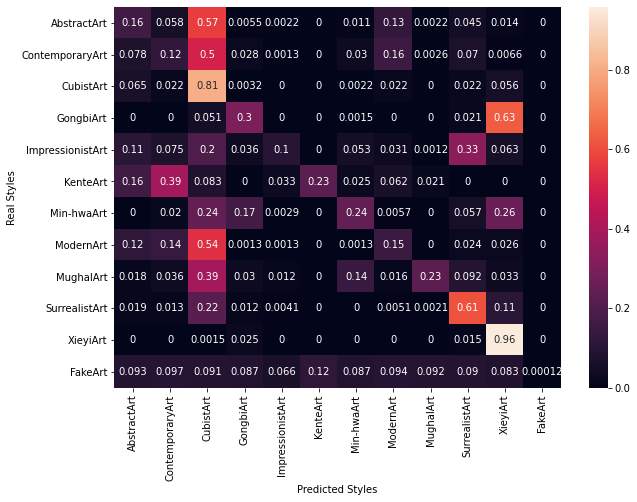

In [129]:
target_labels, generated_images = evaluate_GAN()

#### This cell saves the generator and discriminator trained on 300 epochs

In [52]:
torch.save(generator.state_dict(), "generator300.pth")
torch.save(discriminator.state_dict(), "discriminator300.pth")

### Loading in the generator and the discriminator
(This loads a saved generator/discriminator with wich you can evaluate a dataset). 
This will initialize the weights saved under discriminator2 and generator2
Use evaluate_loaded_GAN(dsc2, gen2) to evaluate 

In [53]:
discriminator2 = Discriminator(input_size, len(art_styles))
discriminator2.load_state_dict(torch.load("discriminator.pth"))
discriminator2.eval()

generator2 = Generator()
generator2.load_state_dict(torch.load("generator.pth"))
generator.eval()

Generator(
  (linear1): Linear(in_features=101, out_features=100, bias=True)
  (ConvSet1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSet2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSet3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSet4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [54]:
def evaluate_loaded_GAN(discriminator, generator):
    '''
    Evaluates the trained GAN on the validation set and generated data
    Prints the accuracy for the discriminator and generator afterwards 
    '''
    # empty cache and initialize for evaluation 
    torch.cuda.empty_cache()
    discriminator.to(device)
    generator.to(device)
    discriminator.eval()
    generator.eval()
    
    # create validation dataloader
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_sizes, shuffle=True)

    # initialize variables for holding correct / total values 
    disc_correct = 0
    disc_total = 0
    gen_correct = 0
    gen_total = 0
    disc_style_correct = [0 for _ in art_styles]
    disc_style_total = [0 for _ in art_styles]
    gen_style_correct = [0 for _ in art_styles]
    gen_style_total = [0 for _ in art_styles]

    # create confusion matrix
    matrix = Confusion_Matrix(len(art_styles))
    
    # evaluate in batches 
    with torch.no_grad():
        for images, labels in validation_loader:
            if(images.shape != torch.Size([batch_sizes, 3, 256, 256])):
                break
            # real images and labels 
            real_images = images.to(device)
            real_labels = labels.to(device)

            # real_labels = torch.ones((batch_sizes, 1))
            data_to_generate, target_labels = rand_generator_input()
            data_to_generate = data_to_generate.to(device)
            target_labels = target_labels.to(device)
            generated_images = generator(data_to_generate.squeeze())
            generated_images = generated_images.to(device)
            generated_labels = gen_fake_labels()
            generated_labels = generated_labels.to(device)

            all_images = torch.cat((real_images, generated_images))
            all_images.to(device)
            all_labels = torch.cat((torch.max(real_labels, 1)[1], torch.max(generated_labels, 1)[1]))
            all_labels.to(device)

            # obtain accuracy of discriminator with both real and fake pictures
            output = discriminator(all_images)
            predictions = output.argmax(dim=1, keepdim=True)
            comparisons = predictions.eq(all_labels.view_as(predictions))

            for comp, label in zip(comparisons, all_labels):
                disc_style_correct[label] += comp.item()
                disc_style_total[label] += 1

            disc_total += all_labels.shape[0]
            disc_correct += int(comparisons.double().sum().item())
            del real_images
            del real_labels

            # obtain accuracy of generator with only fake images
            gen_predictions = torch.reshape(predictions, (2, batch_sizes))[1]
            gen_comparisons = gen_predictions.eq(target_labels.view_as(gen_predictions))

            for comp, label in zip(gen_comparisons, target_labels):
                gen_style_correct[label] += comp.item()
                gen_style_total[label] += 1

            gen_total += target_labels.shape[0]
            gen_correct += int(gen_comparisons.double().sum().item())
            
            # update confusion matrix
            matrix.update(all_labels.unsqueeze(1), predictions)
            
            # delete unnecessary data 
            del data_to_generate
            del all_images
            del all_labels

    # print discriminator accuracy
    disc_accuracy = disc_correct / disc_total
    print(f"Discriminator accuracy on validation set: {disc_correct}/{disc_total} = {disc_accuracy*100:.2f}%")

    for i, label in enumerate(art_styles):
        d_correct = disc_style_correct[i]
        d_total = disc_style_total[i]
        if d_total == 0:
            d_accuracy = 0
        else:
            d_accuracy = d_correct / d_total
        print(f"Discriminator accuracy on {label:>5} class: {d_correct}/{d_total} = {d_accuracy*100:.2f}%")

    # print generator accuracy 
    gen_accuracy = gen_correct / gen_total
    print(f"\nGenerator accuracy on validation set: {gen_correct}/{gen_total} = {gen_accuracy*100:.2f}%")

    for i, label in enumerate(art_styles):
        g_correct = gen_style_correct[i]
        g_total = gen_style_total[i]
        if g_total == 0:
            g_accuracy = 0
        else:
            g_accuracy = g_correct / g_total
        print(f"Generator accuracy on {label:>5} class: {g_correct}/{g_total} = {g_accuracy*100:.2f}%")
    
    # show confusion matrix
    matrix.show()
    
    return target_labels, generated_images


#### This line runs the evaluate_loaded_GAN function

In [55]:
evaluate_loaded_GAN(discriminator2, generator2)

Discriminator accuracy on validation set: 2972/16256 = 18.28%
Discriminator accuracy on AbstractArt class: 141/912 = 15.46%
Discriminator accuracy on ContemporaryArt class: 87/755 = 11.52%
Discriminator accuracy on CubistArt class: 724/924 = 78.35%
Discriminator accuracy on GongbiArt class: 194/671 = 28.91%
Discriminator accuracy on ImpressionistArt class: 82/827 = 9.92%
Discriminator accuracy on KenteArt class: 45/239 = 18.83%
Discriminator accuracy on Min-hwaArt class: 65/348 = 18.68%
Discriminator accuracy on ModernArt class: 115/777 = 14.80%
Discriminator accuracy on MughalArt class: 249/1031 = 24.15%
Discriminator accuracy on SurrealistArt class: 624/972 = 64.20%
Discriminator accuracy on XieyiArt class: 645/672 = 95.98%
Discriminator accuracy on FakeArt class: 1/8128 = 0.01%

Generator accuracy on validation set: 7907/8128 = 97.28%
Generator accuracy on AbstractArt class: 719/719 = 100.00%
Generator accuracy on ContemporaryArt class: 725/725 = 100.00%
Generator accuracy on Cubist

(tensor([ 7,  8,  4,  1,  3, 10,  7,  1, 10,  7,  2,  7,  2,  7,  2,  9,  9,  4,
          7,  8,  2,  3,  1, 10,  4,  1,  3,  6,  7,  0,  6,  4],
        device='cuda:3'),
 tensor([[[[-0.3047, -0.0710, -0.3863,  ..., -0.0296, -0.3063, -0.0445],
           [-0.4065, -0.1944, -0.6944,  ..., -0.3538, -0.5214, -0.2938],
           [-0.3371, -0.5075, -0.7497,  ..., -0.6245, -0.6551, -0.2549],
           ...,
           [-0.3567, -0.2381, -0.5648,  ..., -0.3114, -0.4710, -0.3003],
           [-0.2877, -0.1132, -0.5805,  ..., -0.5822, -0.7135, -0.2046],
           [-0.1726,  0.0132, -0.4875,  ..., -0.1313, -0.3426, -0.0372]],
 
          [[-0.1599, -0.2846, -0.0656,  ..., -0.3239, -0.0819, -0.1049],
           [ 0.0888,  0.2149,  0.0306,  ...,  0.0541,  0.0331, -0.0256],
           [-0.1257, -0.1275,  0.1148,  ..., -0.2210,  0.0779, -0.0539],
           ...,
           [ 0.0387,  0.1874,  0.0950,  ...,  0.1863, -0.1094, -0.0072],
           [-0.1368, -0.2187,  0.0840,  ..., -0.3010,  0.2709,

### Save the generated images to file 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


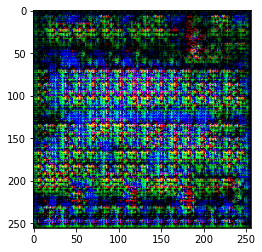

In [20]:
save_generated_image(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


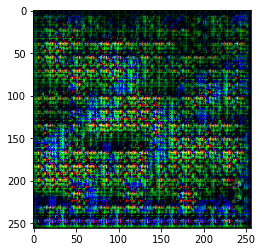

In [21]:
save_generated_image(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


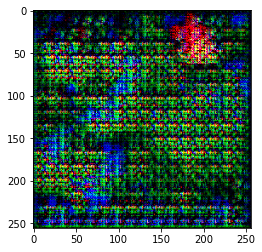

In [22]:
save_generated_image(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


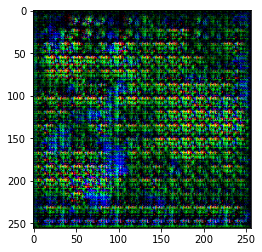

In [23]:
save_generated_image(3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


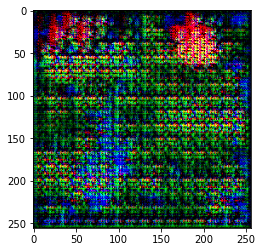

In [24]:
save_generated_image(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


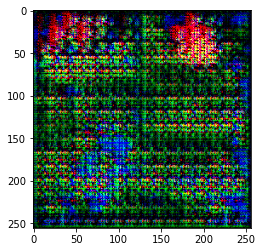

In [25]:
save_generated_image(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


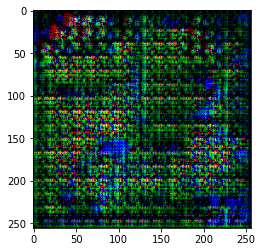

In [26]:
save_generated_image(6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


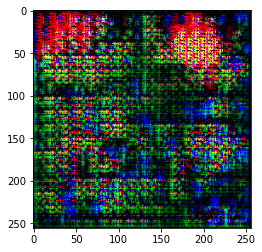

In [27]:
save_generated_image(7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


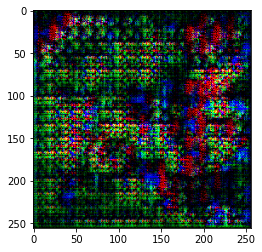

In [28]:
save_generated_image(8)

In [29]:
save_generated_image(9)

RuntimeError: operation does not have an identity.

In [130]:
save_generated_image(10)

RuntimeError: operation does not have an identity.

In [131]:
save_generated_image(11)

RuntimeError: operation does not have an identity.

### Generated images printed from training on 15 epochs

tensor(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


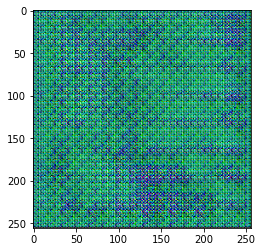

In [185]:
print(target_labels[0].cpu())
plt.imshow(generated_images[0].cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7)


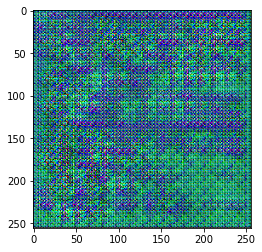

In [186]:
print(target_labels[1].cpu())
plt.imshow(generated_images[1].cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(9)


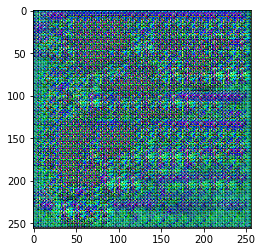

In [187]:
print(target_labels[2].cpu())
plt.imshow(generated_images[2].cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


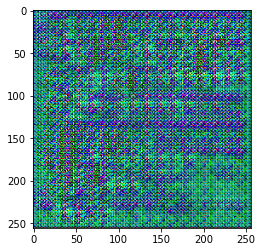

In [189]:
print(target_labels[30].cpu())
plt.imshow(generated_images[30].cpu().permute(1,2,0))